In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy.optimize import fsolve
from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar as sc
import os
from spectrum_class import Spectrum
from molarity_class import Molarity
from diagnostic_class import Diagnostic
import spectrochempy as ch
import re
from scipy.interpolate import griddata

In [5]:
# ----- Obtain the path to the spa folder
path = os.path.dirname(os.getcwd())

path_spa = path + '\\spa data\\'

In [6]:
# Initialize an empty dictionary to store data
data_dict = {}
keys = np.array([0,.4,.7,1,1.3,1.6])

i = 0
# Loop through each inner folder
for molarity_folder in os.listdir(path_spa):
    # Construct the full path to the inner folder
    molarity_folder = os.path.join(path_spa, molarity_folder)
    
    # Check if the path is a directory
    if os.path.isdir(molarity_folder):
        # Initialize an empty list to store data from files in this inner folder
        data = ch.read_omnic(molarity_folder)
        
        data_dict[keys[i]] = data
        i += 1

print(data_dict)

{0.0: NDDataset: [float64] a.u. (shape: (y:65, x:6950)), 0.4: NDDataset: [float64] a.u. (shape: (y:61, x:6950)), 0.7: NDDataset: [float64] a.u. (shape: (y:63, x:6950)), 1.0: NDDataset: [float64] a.u. (shape: (y:63, x:6950)), 1.3: NDDataset: [float64] a.u. (shape: (y:63, x:6950)), 1.6: NDDataset: [float64] a.u. (shape: (y:61, x:6950))}


In [7]:
print(data_dict[0.0].acquisition_date)

None


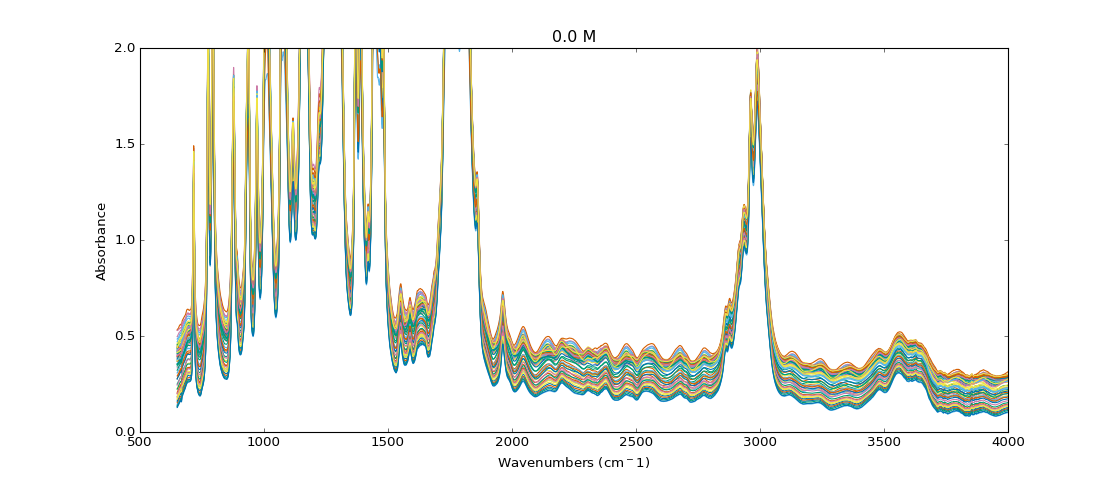

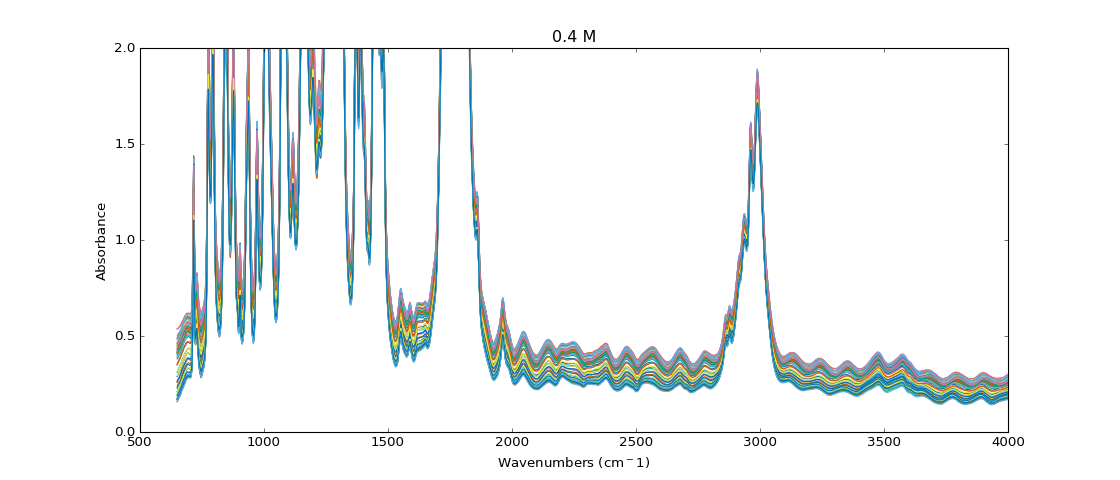

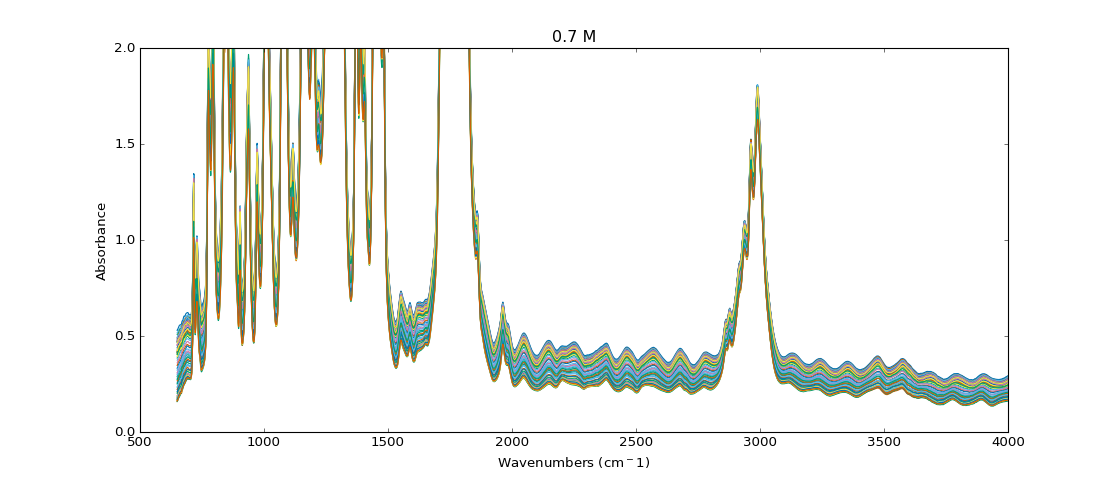

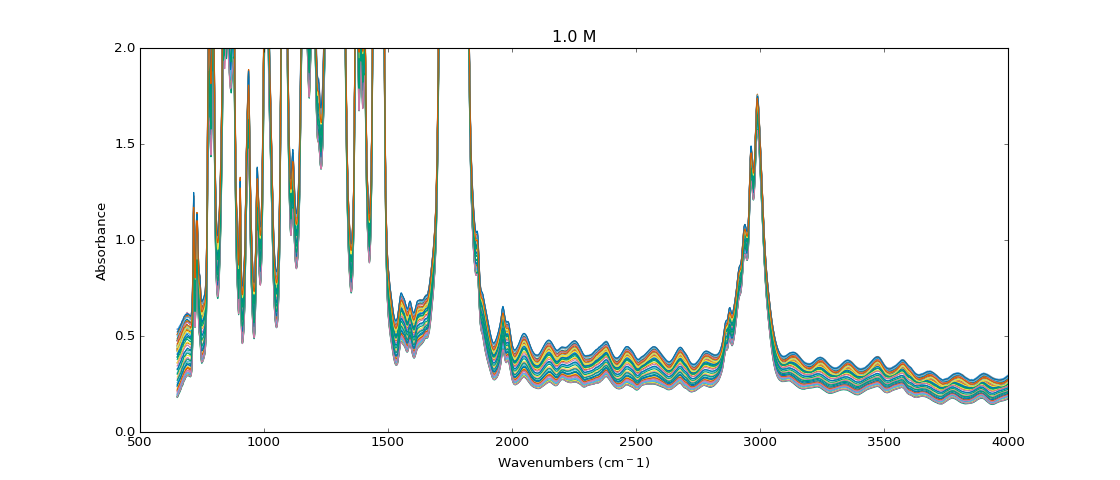

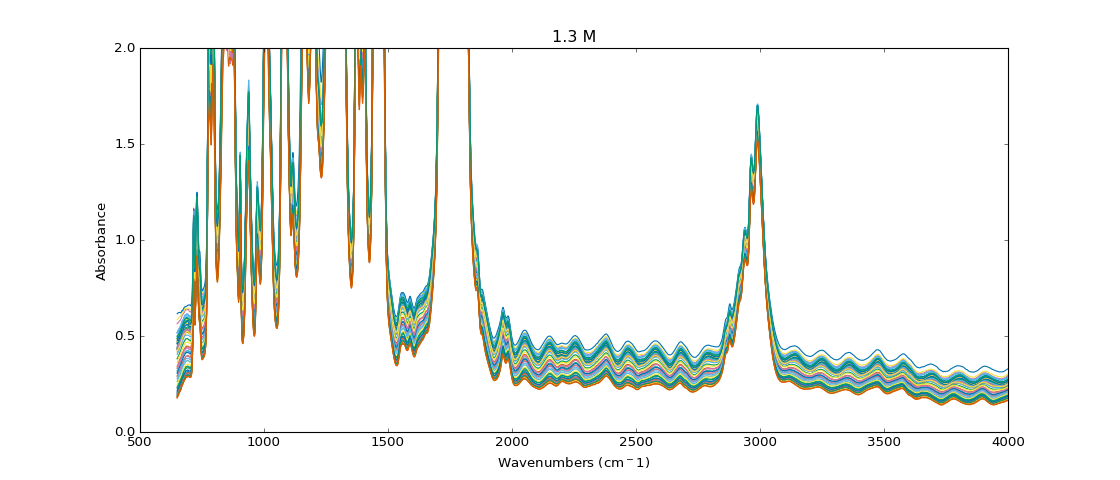

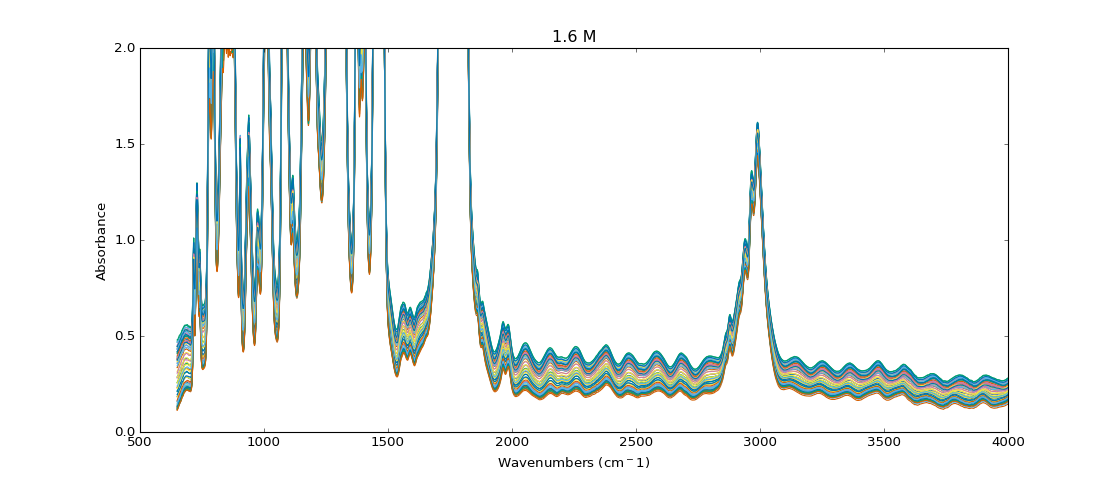

In [8]:

# create Molarity objects from the dictionary
keys = list(data_dict.keys())
Molarities = []
for i in range(len(data_dict)):
    # select an NDDataset object, create a Molarity object
    a = Molarity(obj = data_dict[keys[i]],M = keys[i],smooth = 2.0)

    # add to the list of Molarity arrays
    Molarities.append(a)

# plot each plot
for i in Molarities:
    plt.figure(figsize = (14,6))
    i.plot_all()
    plt.show()


In [ ]:
# ----- Exporting the data to a .csv file
# getting the x data
wavenumbers = Molarities[0].get_x()

aiml = np.array([])
aiml = np.append(aiml,wavenumbers)

titles = np.array(['Wavenumber (cm^-1)'])

# getting the y data
for i in range(len(Molarities)):
    # load the data
    working_object = Molarities[i]
    working_array = working_object.get_all()
    M = working_object.get_M()

    # nested for loop, to parse through the Spectrum objects
    for j in range(len(working_array)):
        working_spectrum = working_array[j]
        working_absorbance = working_spectrum.get_y()

        # append to the array
        aiml = np.vstack((aiml,working_absorbance))
        titles = np.append(titles,str(M + .0000000001 * j) + 'M')

# transpose
aiml = aiml.T


# create pandas dataframe for easy exporting
aiml_pd = pd.DataFrame(aiml,columns = titles)
aiml_pd.set_index('Wavenumber (cm^-1)', inplace=True)


# output
#display(aiml_pd)

In [ ]:
print(path)
aiml_pd.to_csv("aiml2.csv")

In [ ]:
# ----- averaging the data
# getting the x data
wavenumbers = Molarities[0].get_x()

aiml = np.array([])
aiml = np.append(aiml,wavenumbers)

titles = np.array(['Wavenumber (cm^-1)'])

# getting the y data
for i in range(len(Molarities)):
    # load the data
    working_object = Molarities[i]
    working_ys = working_object.get_y()
    M = working_object.get_M()

    aiml = np.vstack((aiml,working_ys))
    titles = np.append(titles,str(M) + 'M')


aiml = aiml.T

data = pd.DataFrame(aiml,columns = titles)
# data.set_index('Wavenumber (cm^-1)', inplace=True)

plt.figure(figsize = (14,6))
for i in range(len(titles) - 1):
    plt.plot(data['Wavenumber (cm^-1)'],data[titles[i + 1]],label = titles[i+1])

plt.xlim(650,2000)
plt.legend()
plt.show()

In [ ]:
absorbances = np.array([data[titles[1]],data[titles[2]],data[titles[3]],data[titles[4]],data[titles[5]],data[titles[6]]])
wavenumbers = data['Wavenumber (cm^-1)']
concentrations = np.array([0.0,0.4,0.7,1.0,1.3,1.6])

# Create an array for the new concentrations from 0M to 1.6M
new_concentrations = np.linspace(0, 1.6, 50)

# Create a 2D grid for the new concentrations and wavenumbers
new_concentrations_grid, wavenumbers_grid = np.meshgrid(new_concentrations, wavenumbers)

# Flatten the arrays for the griddata function
points = np.array([concentrations.repeat(wavenumbers.size), np.tile(wavenumbers, concentrations.size)]).T
values = absorbances.flatten()

# Interpolate the absorbance for each wavenumber and concentration
new_absorbances = griddata(points, values, (new_concentrations_grid, wavenumbers_grid), method='cubic')

print(new_absorbances)

# plot the interpolated data
plt.figure(figsize=(14,6))
for i in range(len(new_concentrations)):
    plt.plot(wavenumbers,new_absorbances[:,i])
    plt.xlim(650,2000)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.title("Interpolated Values from Lydia's Data")

In [ ]:
arr = np.array([[2,2],[4,3],[5,2]])
print(new_absorbances.shape)
print(arr.shape)

# inverse the array to stack the wavenumbers on top
inversed_absorbances = new_absorbances.T                                    # this is data with molarities stacked horizontally
inversed_data = np.vstack((wavenumbers,inversed_absorbances))               # this is the data with the wavenumbers stacked on top

header = np.append(np.array(['Wavenumber (cm^-1)']),new_concentrations)    # this is a header with all of the concentrations
final_data = inversed_data.T                                                # this is the data with the concnetrations going up/down, with the wavenumbers in the leftmost column
# final_array = np.vstack((header,final_data))

final = pd.DataFrame(final_data,columns = header)
final.set_index('Wavenumber (cm^-1)', inplace=True)

display(final)


In [ ]:
final.to_csv(r"C:\\Users\\Modes Lab\\Desktop\\aiml_interpolated.csv")